In [1]:
import torch
import cv2
import copy
import matplotlib.pyplot as plt
from engine.predictor import DefaultPredictor

from  config.config import get_cfg
from model.rcnn import GeneralizedRCNN
from engine.optimizer import build_optimizer,build_lr_scheduler

from data.build import (
    build_detection_test_loader,
    build_detection_train_loader,
)
from data.mapper import DatasetMapper
import data.transforms as T
from data.phase_1 import load_voc_instances,VOC_CLASS_NAMES
from structures.image_list import ImageList
from engine.detection_checkpointer import DetectionCheckpointer
from data.utils import build_augmentation


In [2]:
print(torch.cuda.device_count())
torch.cuda.set_device(1)
print(torch.cuda.current_device())
cfg = get_cfg()
cfg.merge_from_file('./config_files/voc.yaml')
cfg.MODEL.SAVE_IDX=20
cfg.MODEL.RPN.USE_MDN= False
cfg.log = False 
cfg.MODEL.ROI_HEADS.USE_MLN = True
cfg.MODEL.ROI_HEADS.AUTO_LABEL = False
# cfg.MODEL.ROI_HEADS.AF = 'uncertainty'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21
cfg.MODEL.RPN.AUTO_LABEL_TYPE = None
cfg.INPUT.RANDOM_FLIP = "none"
cfg.MODEL.ROI_BOX_HEAD.USE_FD = False
cfg.MODEL.ROI_HEADS.UNCT = True
# cfg.merge_from_list(args.opts)
cfg.freeze()
# wandb.init(config=cfg,tags= 'temp',name = 'temp',project='temp')

2
1


In [3]:
DIR_NAME = '/data/jeongeun/OWOD_datasets/VOC2007'
split = 'test'


In [4]:
RPN_NAME = 'mdn' if cfg.MODEL.RPN.USE_MDN else 'base'
ROI_NAME = 'mln' if cfg.MODEL.ROI_HEADS.USE_MLN else 'base'
MODEL_NAME = RPN_NAME + ROI_NAME
device = 'cuda'
model = GeneralizedRCNN(cfg,device).to(device)
state_dict = torch.load('./ckpt/{}/{}_{}_15000.pt'.format(cfg.MODEL.ROI_HEADS.AF,cfg.MODEL.SAVE_IDX,MODEL_NAME),map_location=device)
state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
model.load_state_dict(state_dict)
predictor = DefaultPredictor(cfg,model)

/home/jeongeun/faster_rcnn_rilab/model/rpn/rpn.py:45: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.weight,std=0.01)
/home/jeongeun/faster_rcnn_rilab/model/rpn/rpn.py:46: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.bias,0)


In [5]:
data = load_voc_instances(DIR_NAME,split,VOC_CLASS_NAMES,phase=None,COCO_CLASS=True)
print(len(data))
mapper = DatasetMapper(is_train=False, augmentations=build_augmentation(cfg,True))
data_loader = build_detection_train_loader(data,mapper=mapper,total_batch_size=1)
IDX = 5000
VOC_CLASS_NAMES_NEW = (*VOC_CLASS_NAMES, 'unknown')

10246


In [6]:
model.roi_heads.box_predictor.path

'./ckpt/baseline/20_basemln.json'

In [21]:

batched_inputs = data.__getitem__(IDX)
gts = batched_inputs['annotations']
gt_bboxs = [a['bbox'] for a in gts]
gt_cls = [a['category_id'] for a in gts]
file_name = batched_inputs['file_name']
img = cv2.imread(file_name)

pred = predictor(img)
pred = pred['instances']._fields
IDX +=5

pred_boxes = pred['pred_boxes']
scores = pred['scores']
pred_classes = pred['pred_classes']
print(pred_classes)
index = torch.where(scores>0.3)[0]

top_pred_boxes = pred_boxes[index]
top_pred_classes = pred_classes[index]


tensor([10, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,  0,
        20, 20, 20, 20, 20, 20], device='cuda:1')


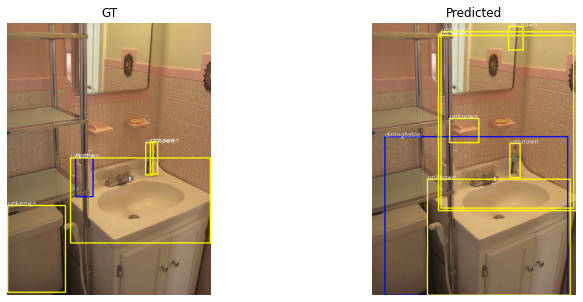

In [22]:

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("GT")
demo_image = copy.deepcopy(img)
for bbox,label in zip(gt_bboxs,gt_cls):
    if label==20:
        color = (0,255,255)
    else:
        color = (255,0,0)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), color, 2)
    cv2.putText(demo_image, VOC_CLASS_NAMES_NEW[int(label)], 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.imshow(demo_image)
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Predicted")
demo_image = copy.deepcopy(img)
for bbox,label in zip(top_pred_boxes,top_pred_classes):
    if label==20:
        color = (0,255,255)
    else:
        color = (255,0,0)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), color, 2)
    cv2.putText(demo_image, VOC_CLASS_NAMES_NEW[int(label)], 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.imshow(demo_image)
plt.axis('off')
plt.savefig('./dummy/roi_head/{}.png'.format(IDX))
plt.show()

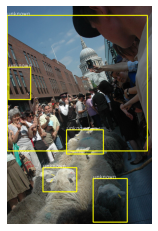

In [9]:
index = (pred_classes==20) & (scores>0.2)
unk_pred_boxes = pred_boxes[index]
unk_pred_classes = pred_classes[index]

demo_image = copy.deepcopy(img)
for bbox,label in zip(unk_pred_boxes,unk_pred_classes):
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), (0, 255, 255), 2)
    cv2.putText(demo_image, VOC_CLASS_NAMES_NEW[int(label)], 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.imshow(demo_image)
plt.axis('off')
plt.show()

## ROI HEAD MLN

In [10]:
print(torch.cuda.device_count())
torch.cuda.set_device(3)
print(torch.cuda.current_device())
cfg = get_cfg()
cfg.merge_from_file('./config_files/voc.yaml')
cfg.MODEL.RPN.USE_MDN=True
cfg.MODEL.ROI_HEADS.USE_MLN=True
cfg.log = False 
cfg.MODEL.ROI_HEADS.AUTO_LABEL = True
cfg.MODEL.ROI_HEADS.AF = 'uncertainty'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21
cfg.INPUT.RANDOM_FLIP = "none"
# cfg.merge_from_list(args.opts)
cfg.freeze()
# wandb.init(config=cfg,tags= 'temp',name = 'temp',project='temp')

2


RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
DIR_NAME = '/data/jeongeun/OWOD_datasets/VOC2007'
split = 'train'


In [ ]:
model = GeneralizedRCNN(cfg).to('cuda')
state_dict = torch.load('./ckpt/uncertainty/1_mdn_17500.pt')
model.load_state_dict(state_dict)
predictor = DefaultPredictor(cfg,model)

USE MDN


In [ ]:
data = load_voc_instances(DIR_NAME,split,VOC_CLASS_NAMES,phase=None,eval_OS=True)
print(len(data))
mapper = DatasetMapper(is_train=True, augmentations=build_augmentation(cfg,True))
data_loader = build_detection_train_loader(data,mapper=mapper,total_batch_size=1)
IDX = 5000
VOC_CLASS_NAMES_NEW = (*VOC_CLASS_NAMES, 'unknown')

eval
10246


In [ ]:

batched_inputs = data.__getitem__(IDX)
gts = batched_inputs['annotations']
gt_bboxs = [a['bbox'] for a in gts]
gt_cls = [a['category_id'] for a in gts]
file_name = batched_inputs['file_name']
img = cv2.imread(file_name)

pred = predictor(img)
pred = pred['instances']
IDX +=1

demo_image = copy.deepcopy(img)
for bbox,label in zip(gt_bboxs,gt_cls):
    if label==20:
        color = (0,255,255)
    else:
        color = (255,0,0)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), color, 2)
    cv2.putText(demo_image, VOC_CLASS_NAMES_NEW[int(label)], 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.imshow(demo_image)
plt.axis('off')
plt.show()

TypeError: inference() takes 3 positional arguments but 4 were given

In [ ]:
epis = pred.epis
alea = pred.alea - 1
unct = epis + alea
pred_boxes = pred.pred_boxes
scores = pred.scores
pred_classes = pred.pred_classes
print(pred_classes)
# print(unct,epis,alea)
index = torch.where(scores>0.3)[0]

top_pred_boxes = pred_boxes[index]
top_pred_classes = pred_classes[index]
top_unct= unct[index]

tensor([ 6,  6, 20, 20, 14, 20, 20, 11,  3, 12,  8, 20,  8, 20,  8,  8, 20,  6,
         8, 20, 20, 10,  8, 20,  8,  8, 20,  8, 20,  8, 20,  8,  4, 20,  8, 20,
        14,  8], device='cuda:3')


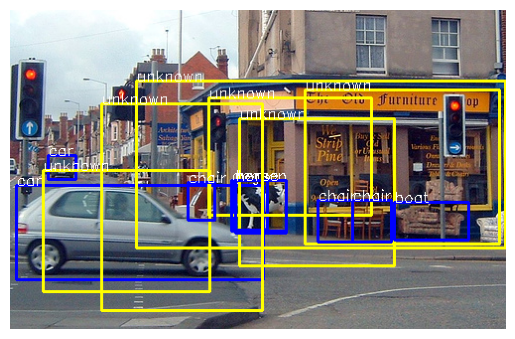

In [ ]:
demo_image = copy.deepcopy(img)
for bbox,label,ep in zip(top_pred_boxes,top_pred_classes,top_unct):
    if label==20:
        color = (0,255,255)
    else:
        color = (255,0,0)
    cv2.rectangle(demo_image, (int(bbox[0]), int(bbox[1])), 
                        (int(bbox[2]),int(bbox[3])), color, 2)
    cv2.putText(demo_image, VOC_CLASS_NAMES_NEW[int(label)], 
                            (int(bbox[0]), int(bbox[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
demo_image = cv2.cvtColor(demo_image, cv2.COLOR_RGB2BGR)
plt.imshow(demo_image)
plt.axis('off')
plt.show()